In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from project import run

# setting display options
%matplotlib inline
pd.set_option('display.width', 4000)
pd.set_option('max_colwidth', 4000)
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 200)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
my_path = r'.\data\insurance.db'

df = run(my_path, nb_exploration=True)

NaN values of "Area" column were imputed.
NaN values of "Education" column were imputed.
NaN values of "Children" column were imputed.
   Education  Salary Area Children     CMV  Claims  Motor  Household  Health  Life  Work_Compensation  Age  Customer_Years
ID                                                                                                                        
1       2.00    2177 1.00     1.00  380.97    0.39   0.57      -0.55   -0.29  0.24              -0.54   34              31
2       2.00     677 4.00     1.00 -131.13    1.12  -1.59       0.96   -0.69  0.00               1.75   21              35


In [3]:
df.head()

,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work_Compensation,Age,Customer_Years
ID,,,,,,,,,,,,,
1,2.00,2177,1.00,1.00,380.97,0.39,0.57,-0.55,-0.29,0.24,-0.54,34,31
2,2.00,677,4.00,1.00,-131.13,1.12,-1.59,0.96,-0.69,0.00,1.75,21,35
3,1.00,2277,3.00,0.00,504.67,0.28,-0.66,0.10,-0.58,1.27,1.57,46,25
4,3.00,1099,4.00,1.00,-16.99,0.99,-0.83,-0.71,1.92,-0.07,-0.24,35,26
5,3.00,1763,4.00,1.00,35.23,0.90,0.30,-0.69,0.20,-0.50,0.09,43,30


In [4]:
df.dtypes

Education            category
Salary                  int32
Area                 category
Children             category
CMV                   float64
Claims                float64
Motor                 float64
Household             float64
Health                float64
Life                  float64
Work_Compensation     float64
Age                     int32
Customer_Years          int32
dtype: object

In [5]:
df.isna().any().any()

False

In [6]:
premiums_cols = ["Motor", "Household", "Health", "Life", "Work_Compensation"]
categorical_cols = ["Area", "Education", "Children"]

In [7]:
# cols_for_clustering = []
# cols_for_clustering.extend(premiums_cols)
# cols_for_clustering.extend(categorical_cols)

In [8]:
# might be handy: https://github.com/joaolcorreia/RFM-analysis

In [9]:
from sklearn.preprocessing import StandardScaler
df[:] = StandardScaler().fit_transform(df[:])

x = df[df.columns.difference(categorical_cols)].values # excluding categorical columns
x = x[:200] # slice array for faster cluster testing

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

print(pca.explained_variance_ratio_)

[0.92167486 0.02667309]


In [11]:
principalDf.head(2)

,principal component 1,principal component 2
0,-0.87,-0.46
1,-0.51,2.25


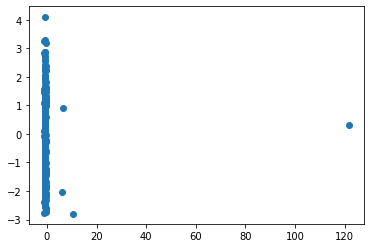

In [12]:
plt.scatter(principalComponents[:,0], principalComponents[:,1])
plt.show()

### K-Means Clustering

In [13]:
from sklearn.cluster import KMeans

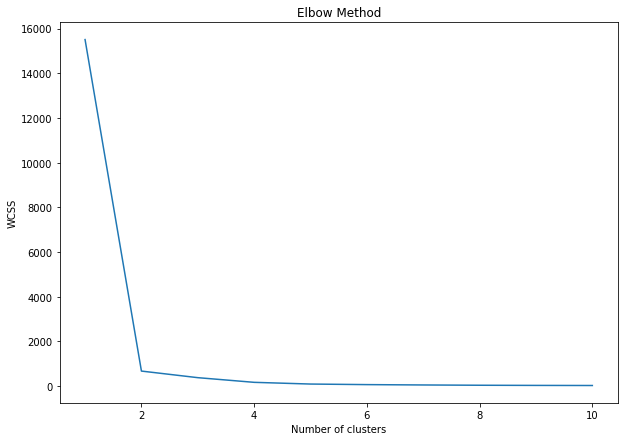

In [14]:
plt.figure(figsize=(10, 7))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(principalComponents)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [15]:
best_number_of_clusters = 2

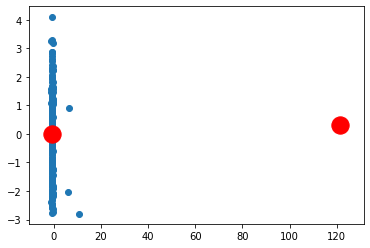

In [16]:
kmeans = KMeans(n_clusters=best_number_of_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(principalComponents)
plt.scatter(principalComponents[:,0], principalComponents[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

### Agglomerative Clustering

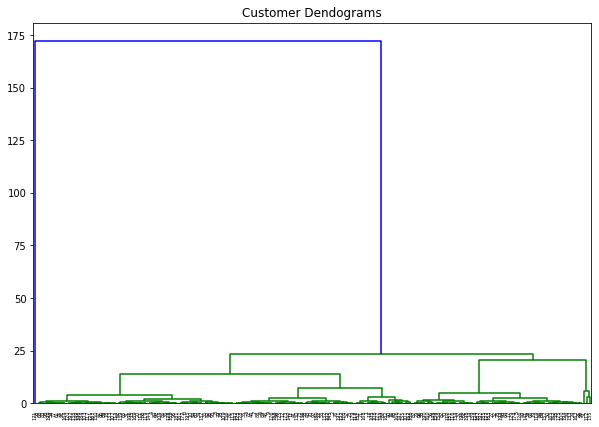

In [17]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(principalComponents, method='ward'))

In [18]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 2

cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster.fit_predict(principalComponents)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

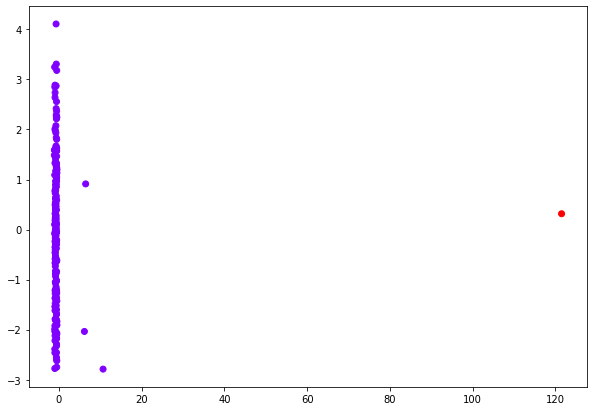

In [19]:
plt.figure(figsize=(10, 7))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=cluster.labels_, cmap='rainbow')

plt.show()